# COURSE: A deep understanding of deep learning
## SECTION: Autoencoders
### LECTURE: The latent code of MNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# NEW! for doing PCA on the model output
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# we'll use the labels for matching with the latent code
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# Create the DL model

In [3]:
# create a class for the model
def createTheMNISTAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,150)

      ### encoder layer
      self.enc = nn.Linear(150,15)

      ### latent layer
      self.lat = nn.Linear(15,150)

      ### decoder layer
      self.dec = nn.Linear(150,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )

      # NEW! output the hidden-layer activation
      codex = F.relu( self.enc(x) )

      x = F.relu( self.lat(codex) )
      y = torch.sigmoid( self.dec(x) )
      return y,codex

  # create the model instance
  net = aenet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [4]:
# test the model with a bit of data
net,lossfun,optimizer = createTheMNISTAE()

X = dataT[:5,:]
yHat = net(X)

print('Input shape:')
print(X.shape)
print(' ')

# yHat is now a tuple
print(type(yHat),len(yHat))
print(' ')

print('Shape of model output:')
print(yHat[0].shape)
print(' ')

print('Shape of encoding layer output:')
print(yHat[1].shape)

Input shape:
torch.Size([5, 784])
 
<class 'tuple'> 2
 
Shape of model output:
torch.Size([5, 784])
 
Shape of encoding layer output:
torch.Size([5, 15])


# Create a function that trains the model

In [5]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10000

  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  # initialize losses
  losses = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # select a random set of images
    randomidx = np.random.choice(dataT.shape[0],size=32)
    X = dataT[randomidx,:]

    # forward pass and loss
    yHat = net(X)[0] # NEW! here we only care about the final model output
    loss = lossfun(yHat,X)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # losses in this epoch
    losses[epochi] = loss.item()
  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

Final loss: 0.0157


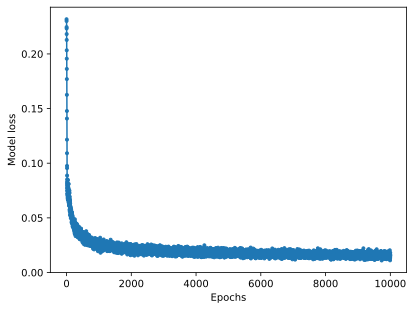

In [6]:
# train the model
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

# Inspect the latent "code" of the model

torch.Size([20000, 784])
torch.Size([20000, 15])


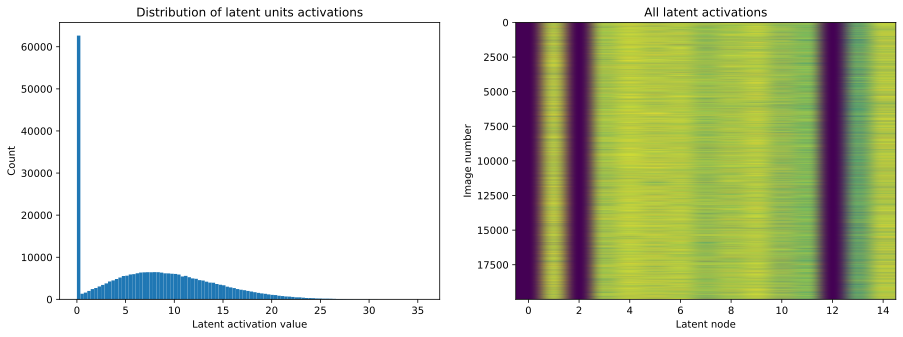

In [22]:
# output the latent layer

# push through the entire dataset
yHat,latent = net(dataT)

# print sizes
print(yHat.shape)
print(latent.shape)

# what does it look like?
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(latent.flatten().detach(),100)
ax[0].set_xlabel('Latent activation value')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of latent units activations')

ax[1].imshow(latent.detach(),aspect='auto',vmin=0,vmax=10)
ax[1].set_xlabel('Latent node')
ax[1].set_ylabel('Image number')
ax[1].set_title('All latent activations')


plt.show()

In [17]:
# np.mean(latent[0,:].data.numpy())


tensor(5.6560, grad_fn=<MeanBackward0>)

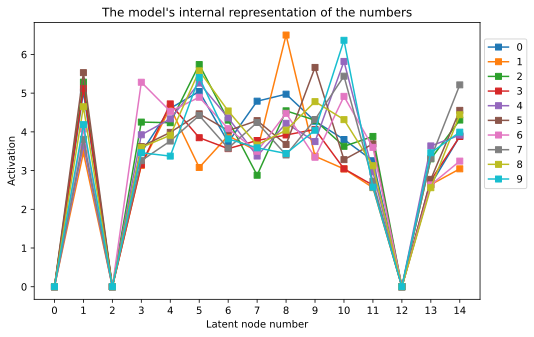

In [28]:
# compute the average latent activation for each digit type

# initialize output matrix (latent shape by 10 digits)
sourcecode = np.zeros((latent.shape[1],10))


# loop over digit categories
for i in range(10):

  # find all pictures of this category
  digidx = np.where(labels==i)

  # average the latent layer output
  # sourcecode[:,i] = torch.mean(latent[digidx,:],axis=1).detach()
  sourcecode[:,i] = np.std(latent[digidx,:].detach().numpy(),axis=1)


# let's see what it looks like!
fig = plt.figure(figsize=(8,5))

plt.plot(sourcecode,'s-')
plt.legend(range(10),loc=(1.01,.4))
plt.xticks(range(15))
plt.xlabel('Latent node number')
plt.ylabel('Activation')
plt.title("The model's internal representation of the numbers")
plt.show()

# Explore the reduced-compressed space with PCA

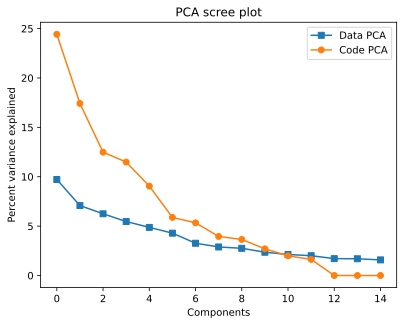

In [24]:
# compute and fit the PCA
pcaData = PCA(n_components=15).fit(data) # 15 components to match latent, but it's just to speed computation time
pcaCode = PCA(               ).fit(latent.detach())


# plot the eigenspectra (scree plot)
plt.plot(100*pcaData.explained_variance_ratio_,'s-',label='Data PCA')
plt.plot(100*pcaCode.explained_variance_ratio_,'o-',label='Code PCA')
plt.xlabel('Components')
plt.ylabel('Percent variance explained')
plt.title('PCA scree plot')
plt.legend()
plt.show()

In [25]:
# compute the projection of the data onto the PC axes
scoresData = pcaData.fit_transform(data)
scoresCode = pcaCode.fit_transform(latent.detach())

# plot the data separately per number
fig,ax = plt.subplots(1,2,figsize=(15,5))

for lab in range(10):
  ax[0].plot(scoresData[labels==lab,0],scoresData[labels==lab,1],'o',markersize=3,alpha=.4)
  ax[1].plot(scoresCode[labels==lab,0],scoresCode[labels==lab,1],'o',markersize=3,alpha=.4)

for i in range(2):
  ax[i].set_xlabel('PC1 projection')
  ax[i].set_ylabel('PC2 projection')
  ax[i].legend(range(10))

ax[0].set_title('PCA of data')
ax[1].set_title('PCA of latent code')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

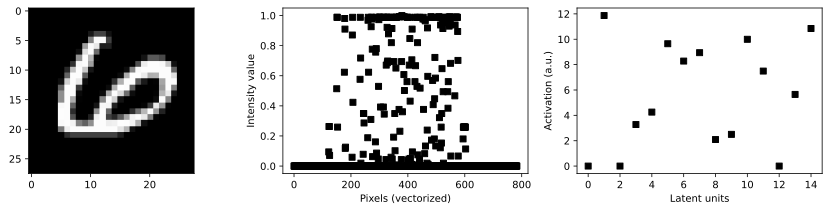

In [26]:
# This cell is not important! It's just the code I used to make the figure in the slide. I decided to leave it here FYI.

fig,ax = plt.subplots(1,3,figsize=(15,3))

ax[0].imshow(dataT[0,:].view(28,28),cmap='gray')

ax[1].plot(dataT[0,:],'ks')
ax[1].set_xlabel('Pixels (vectorized)')
ax[1].set_ylabel('Intensity value')

ax[2].plot(latent[0,:].detach(),'ks')
ax[2].set_xlabel('Latent units')
ax[2].set_ylabel('Activation (a.u.)')

plt.show()

# Additional explorations

In [ ]:
# 1) Are you surprised that the latent activations (e.g., from the histogram) are all non-negative? Is that because of
#    the image normalization, or what is causing those values to be all non-negative?
#
# 2) Averages don't tell the whole story. Redraw the "Model's internal representation" line plot but using standard
#    deviation instead of mean. This graph will tell you if any numbers, or units, have particularly higher variability
#    than others. Is this the case, and does the std plot give you any more insight into the model's learned representation?
#
# 3) The PC-space plots are tricky to interpret: This is a 15-dimensional space but 13 dimensions are projected onto two.
#    It's possible that the numbers are better separated in other dimensions, just like a 2D photograph of someone standing
#    behind a tree makes them inseparable whereas they are separable in the original 3D space. Modify the plot to show
#    PC dimensions 2&3 instead of 1&2.
#